In [5]:
import kagglehub
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import string
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from transformers import BertTokenizerFast
from collections import Counter
import matplotlib.pyplot as plt
from nltk import ngrams
from wordcloud import WordCloud

In [6]:
path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")

Using Colab cache for faster access to the 'ai-vs-human-text' dataset.


In [7]:
TEXT_BASE_DIR = Path(path)
TEXT_BASE_DIR

PosixPath('/kaggle/input/ai-vs-human-text')

In [8]:
text_df_path = os.path.join(TEXT_BASE_DIR, 'AI_Human.csv')
text_df = pd.read_csv(text_df_path)
text_df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


##basic info of data

In [9]:
print('not AI texts:', (text_df["generated"] == 0.0).sum())
print('AI gen texts:', (text_df["generated"] == 1.0).sum())

not AI texts: 305797
AI gen texts: 181438


<Axes: xlabel='generated', ylabel='count'>

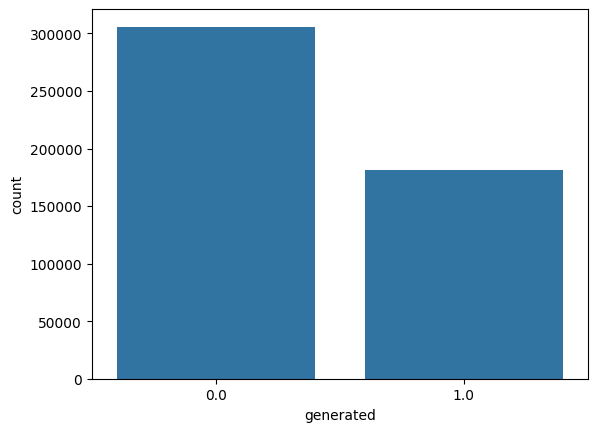

In [10]:
sns.countplot(data = text_df, x = "generated")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

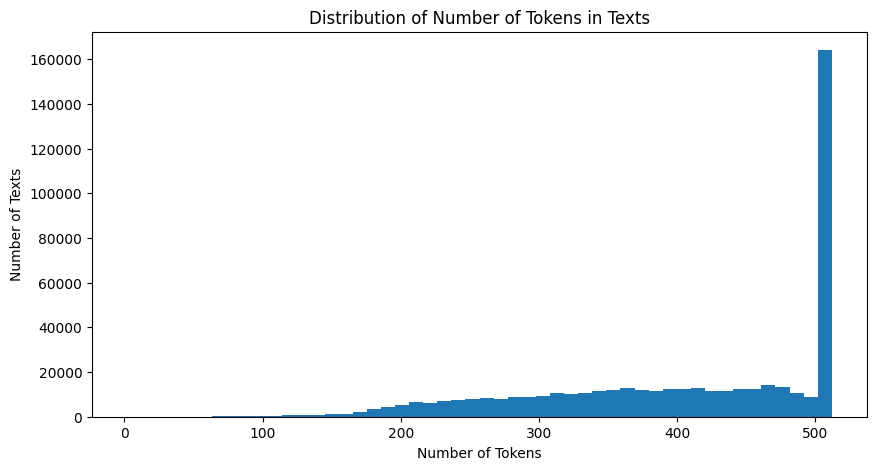

Maximum token length for the tokenizer: 512
Maximum number of tokens in a text: 512
95th percentile of number of tokens in a text: 512.0


In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
max_length = tokenizer.model_max_length
df_visualization = text_df.copy()
texts = df_visualization['text'].tolist()
encodings = tokenizer(
    texts,
    truncation=True,
    max_length=max_length,
    padding=False,
    return_attention_mask=False,
    return_token_type_ids=False
)
df_visualization['num_tokens'] = [len(ids) for ids in encodings['input_ids']]

plt.figure(figsize=(10, 5))
plt.hist(df_visualization['num_tokens'], bins=50)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Texts')
plt.title('Distribution of Number of Tokens in Texts')
plt.show()
print(f'Maximum token length for the tokenizer: {max_length}')
print(f"Maximum number of tokens in a text: {df_visualization['num_tokens'].max()}")
print(f"95th percentile of number of tokens in a text: {df_visualization['num_tokens'].quantile(0.95)}")

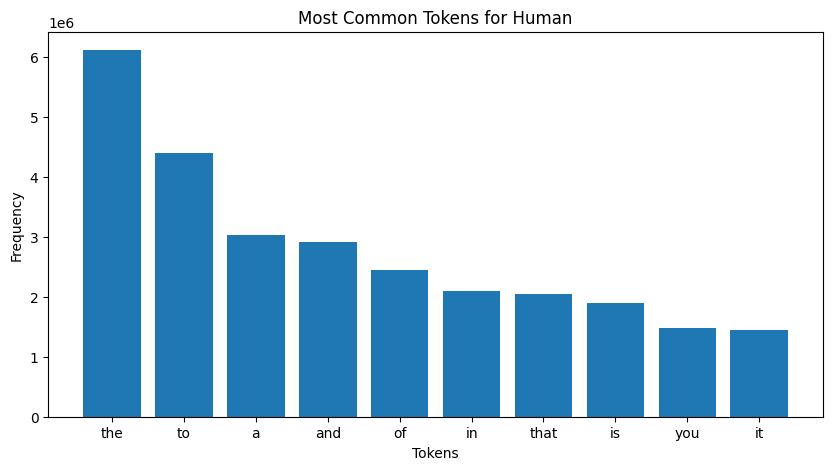

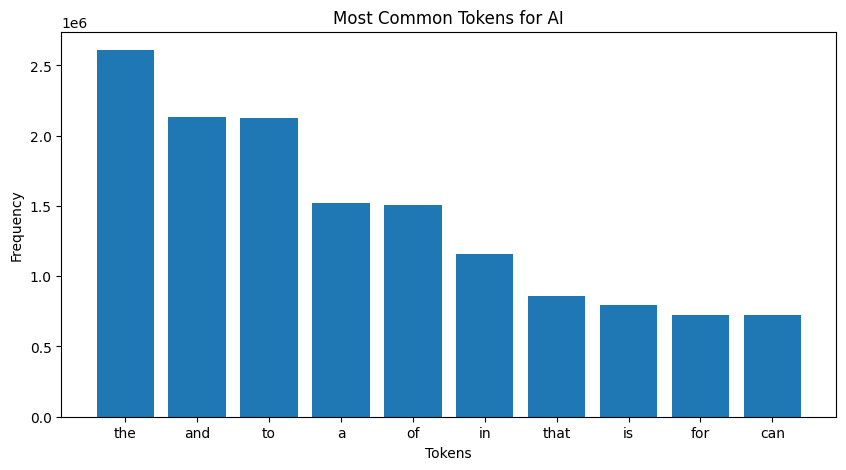

In [ ]:
def plot_common_tokens(df, class_value):
    df_class = df[df['generated'] == class_value]
    class_map = {0: 'Human', 1: 'AI'}

    token_freq = Counter(token for tokens in df_class['tokens'] for token in tokens if token not in string.punctuation)

    common_tokens = token_freq.most_common(10)
    tokens, counts = zip(*common_tokens)

    plt.figure(figsize=(10, 5))
    plt.bar(tokens, counts)
    plt.title(f'Most Common Tokens for {class_map[class_value]}')
    plt.xlabel('Tokens')
    plt.ylabel('Frequency')
    plt.show()

df_visualization = text_df.copy()
df_visualization['text'] = df_visualization['text'].str.lower()
df_visualization['tokens'] = df_visualization['text'].apply(lambda x: x.split())

plot_common_tokens(df_visualization, 0)
plot_common_tokens(df_visualization, 1)

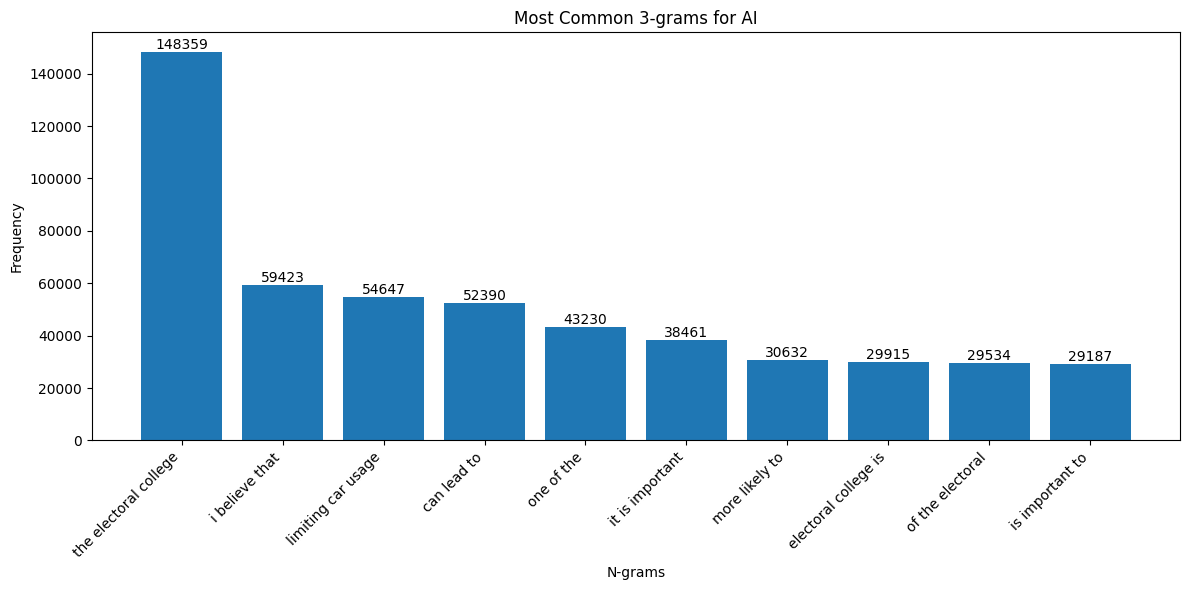

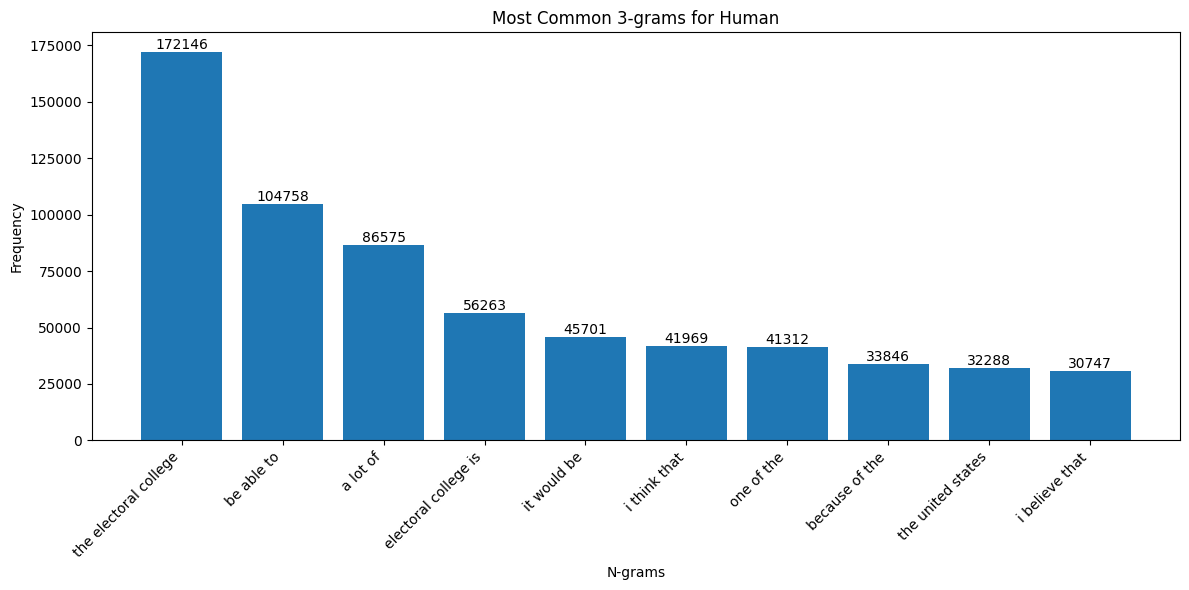

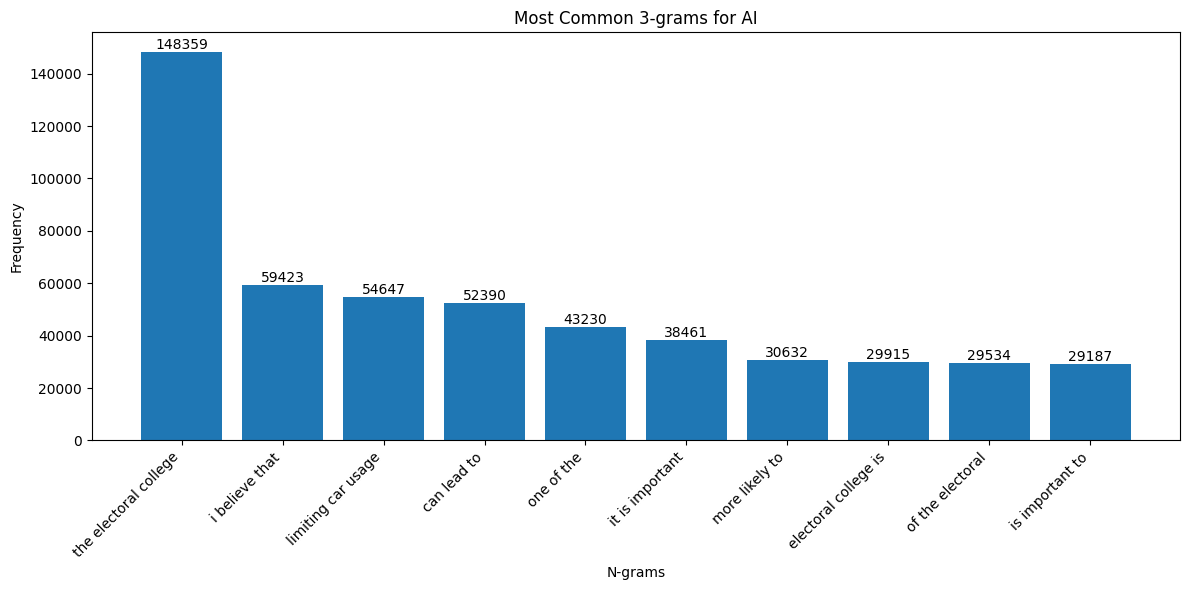

In [ ]:
def plot_common_ngrams(df, class_value, n, figsize=(12, 6)):
    df_class = df[df['generated'] == class_value].copy()
    class_map = {0: 'Human', 1: 'AI'}

    if df_class.empty:
        raise ValueError(f"No data found for class {class_map[class_value]}")

    # Initializing empty Counter
    ngram_freq = Counter()

    # Processing each token sequence
    for tokens in df_class['tokens']:
        # Skip if tokens is None or empty
        if not tokens:
            continue

        # Ensure tokens is a list
        if isinstance(tokens, str):
            tokens = tokens.split()

        # Generate n-grams only if sequence is long enough
        if len(tokens) >= n:
            try:
                sequence_ngrams = list(ngrams(tokens, n))
                ngram_freq.update(sequence_ngrams)
            except (TypeError, RuntimeError) as e:
                print(f"Warning: Could not generate n-grams for sequence: {tokens[:50]}...")
                continue

    if not ngram_freq:
        raise ValueError(f"No valid {n}-grams could be generated for {class_map[class_value]}")

    # Most common n-grams
    common_ngrams = ngram_freq.most_common(10)
    if not common_ngrams:
        raise ValueError(f"No common {n}-grams found for {class_map[class_value]}")

    # Unzipping the n-grams and counts
    ngrams_, counts = zip(*common_ngrams)

    # Creating the plot
    plt.figure(figsize=figsize)

    # Creating readable labels by joining n-gram tokens
    labels = [' '.join(ngram) for ngram in ngrams_]

    # Plotting bars
    bars = plt.bar(range(len(counts)), counts, align='center')

    # Customizing the plot
    plt.title(f'Most Common {n}-grams for {class_map[class_value]}')
    plt.xlabel('N-grams')
    plt.ylabel('Frequency')

    # Setting x-axis labels
    plt.xticks(range(len(counts)), labels, rotation=45, ha='right')

    # Adding value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    # Adjusting layout to prevent label cutoff
    plt.tight_layout()

    return plt.gcf()

plot_common_ngrams(df_visualization, 0, 3)
plot_common_ngrams(df_visualization, 1, 3)

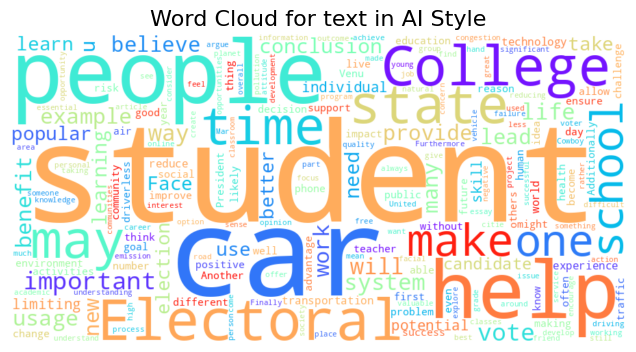

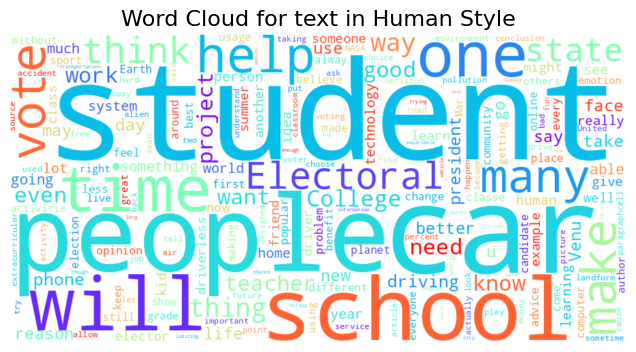

In [ ]:
def create_wordcloud(data, column, title):
    wordcloud = WordCloud(
        width=900,
        height=450,
        background_color='white',
        colormap='rainbow',
        collocations=False,
        prefer_horizontal=0.7,
    ).generate(' '.join(data[column]))
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {column} in {title}', fontsize=16, color='black')
    plt.axis('off')
    plt.show()
create_wordcloud(text_df[text_df["generated"] == 1.0], 'text', 'AI Style')
create_wordcloud(text_df[text_df["generated"] == 0.0], 'text', 'Human Style')

In [11]:
text_df["text"][0]

'Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.\n\nIn like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article

In [12]:
def remove_tags(text):
    tags = ['\n', '\'']
    for tag in tags:
        text = text.replace(tag, '')
    return text
def remove_punc(text):
    new_text = [x for x in text if x not in string.punctuation]
    new_text = ''.join(new_text)
    return new_text


In [13]:
text_df["text"] = text_df["text"].apply(remove_tags)
text_df["text"] = text_df["text"].apply(remove_punc)

In [14]:
text_df["text"][0]

'Cars Cars have been around since they became famous in the 1900s when Henry Ford created and built the first ModelT Cars have played a major role in our every day lives since then But now people are starting to question if limiting car usage would be a good thing To me limiting the use of cars might be a good thing to doIn like matter of this article In German Suburb Life Goes On Without Cars by Elizabeth Rosenthal states how automobiles are the linchpin of suburbs where middle class families from either Shanghai or Chicago tend to make their homes Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europeand up to 50 percent in some carintensive areas in the United States Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go Article Paris bans driving due to 

In [15]:
y = text_df["generated"]
X = text_df["text"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [17]:
print(len(X_train))
print(len(y_train))

341064
341064


In [18]:
pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('naive_bayes', MultinomialNB())])

In [19]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                ('tfidf_transformer', TfidfTransformer()),
                ('naive_bayes', MultinomialNB())])

In [20]:
y_pred = pipeline.predict(X_test)

In [21]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     91597
         1.0       0.99      0.87      0.93     54574

    accuracy                           0.95    146171
   macro avg       0.96      0.93      0.94    146171
weighted avg       0.95      0.95      0.95    146171



In [22]:
def predict_ai_percent_sklearn(text: str) -> float:
    prob = pipeline.predict_proba([text])[0][1]
    return prob * 100.0

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
def test_file_probability(file_name: str):
    test_file = "/content/drive/MyDrive/data/" + file_name + ".txt"
    print(f"Using file: '{file_name}':")

    try:
        with open(test_file, "r", encoding="utf-8") as f:
            text = f.read()
    except FileNotFoundError:
        print(f"Error: The file '{test_file}' was not found.")
        return
    except Exception as e:
        print(f"An error occurred: {e}")
        return

    percent = predict_ai_percent_sklearn(text)
    print(f"Predicted AI probability of '{file_name}': {percent:.2f}%\n")

In [25]:
def main():
    file_list = [
        "test_specimen_easy",
        "test_specimen_easy_2",
        "test_specimen_easy_3",
        "test_specimen_moderate",
        "test_specimen_hard",
        "test_specimen_human"
    ]

    for f in file_list:
        test_file_probability(f)


if __name__ == "__main__":
    main()

Using file: 'test_specimen_easy':
Predicted AI probability of 'test_specimen_easy': 99.15%

Using file: 'test_specimen_easy_2':
Predicted AI probability of 'test_specimen_easy_2': 99.84%

Using file: 'test_specimen_easy_3':
Predicted AI probability of 'test_specimen_easy_3': 93.19%

Using file: 'test_specimen_moderate':
Predicted AI probability of 'test_specimen_moderate': 99.96%

Using file: 'test_specimen_hard':
Predicted AI probability of 'test_specimen_hard': 55.11%

Using file: 'test_specimen_human':
Predicted AI probability of 'test_specimen_human': 9.64%

